In [ ]:
#Connect to G Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Set working directory
%cd /content/drive/MyDrive/super_resolution/

/content/drive/MyDrive/super_resolution


In [ ]:
#I changed working directory to import this Subpixed
from Subpixel import Subpixel

In [ ]:
import cv2, os, glob
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Input, Activation
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from skimage.transform import pyramid_expand
from DataGenerator import DataGenerator

In [ ]:
# Be careful to set base_path :) 
base_path = '/content/drive/MyDrive/super_resolution/processed'

x_train_list = sorted(glob.glob(os.path.join(base_path, 'x_train', '*.npy')))
x_val_list = sorted(glob.glob(os.path.join(base_path, 'x_val', '*.npy')))

print(len(x_train_list), len(x_val_list))
print(x_train_list[0])

8800 200
/content/drive/MyDrive/super_resolution/processed_two/x_train/000001.npy


(44, 44, 3) (44, 44, 3)


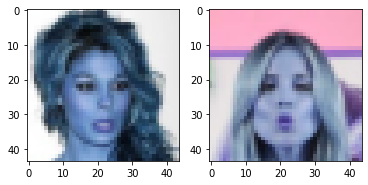

In [ ]:
x1 = np.load(x_train_list[5])
x2 = np.load(x_val_list[5])

print(x1.shape, x2.shape)

plt.subplot(1, 2, 1)
plt.imshow(x1)
plt.subplot(1, 2, 2)
plt.imshow(x2)

In [ ]:
train_gen = DataGenerator(list_IDs=x_train_list, 
                          labels=None, 
                          batch_size=16, 
                          dim=(44,44), 
                          n_channels=3, 
                          n_classes=None, 
                          shuffle=True)

val_gen = DataGenerator(list_IDs=x_val_list, 
                        labels=None, 
                        batch_size=16, 
                        dim=(44,44), 
                        n_channels=3, 
                        n_classes=None, 
                        shuffle=False)

In [ ]:
upscale_factor = 4

inputs = Input(shape=(44, 44, 3))

net = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
net = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Conv2D(filters=upscale_factor**2, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Subpixel(filters=3, kernel_size=3, r=upscale_factor, padding='same')(net)
outputs = Activation('relu')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 44, 44, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 44, 44, 64)        4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 16)        4624      
_________________________________________________________________
subpixel (Subpixel)          (None, 176, 176, 3)       6960      
_________________________________________________________________
activation (Activation)      (None, 176, 176, 3)       0     

In [ ]:
history = model.fit_generator(train_gen, 
                              validation_data=val_gen, 
                              epochs=10, 
                              verbose=1, 
                              callbacks=[ModelCheckpoint('/content/drive/MyDrive/super_resolution/models/model.h5', monitor='val_loss', verbose=1, save_best_only=True)])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
550/550 [==============================] - 4039s 7s/step - loss: 0.0338 - val_loss: 0.0028

Epoch 00001: val_loss improved from inf to 0.00277, saving model to /content/drive/MyDrive/super_resolution/models/model.h5
Epoch 2/10
550/550 [==============================] - 180s 328ms/step - loss: 0.0029 - val_loss: 0.0022

Epoch 00002: val_loss improved from 0.00277 to 0.00217, saving model to /content/drive/MyDrive/super_resolution/models/model.h5
Epoch 3/10
550/550 [==============================] - 177s 321ms/step - loss: 0.0025 - val_loss: 0.0020

Epoch 00003: val_loss improved from 0.00217 to 0.00199, saving model to /content/drive/MyDrive/super_resolution/models/model.h5
Epoch 4/10
550/550 [==============================] - 179s 325ms/step - loss: 0.0021 - val_loss: 0.0019

Epoch 00004: val_loss improved from 0.00199 to 0.00191, saving model to /content/drive/MyDrive/super_resolution/models/model.h5
Epoch 5/10
550/550 [==============================] - 180s 327ms/step - lo

In [ ]:
x_test_list = sorted(glob.glob(os.path.join(base_path, 'x_test', '*.npy')))
y_test_list = sorted(glob.glob(os.path.join(base_path, 'y_test', '*.npy')))

print(len(x_test_list), len(y_test_list))
print(x_test_list[0])

1000 1000
/content/drive/MyDrive/super_resolution/processed_two/x_test/009001.npy


(44, 44, 3) (176, 176, 3)


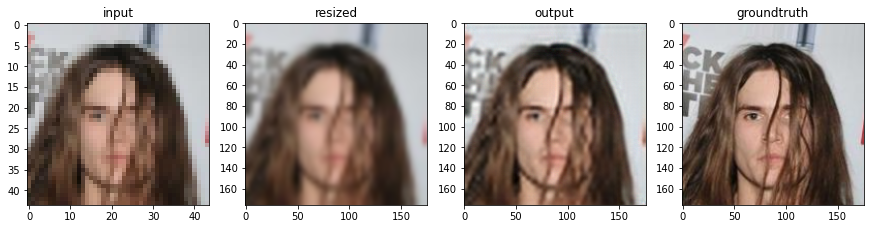

In [ ]:
test_idx = 15

x1_test = np.load(x_test_list[test_idx])
x1_test_resized = pyramid_expand(x1_test, 4, multichannel=True)
y1_test = np.load(y_test_list[test_idx])
y_pred = model.predict(x1_test.reshape((1, 44, 44, 3)))

print(x1_test.shape, y1_test.shape)

x1_test = (x1_test * 255).astype(np.uint8)
x1_test_resized = (x1_test_resized * 255).astype(np.uint8)
y1_test = (y1_test * 255).astype(np.uint8)
y_pred = np.clip(y_pred.reshape((176, 176, 3)), 0, 1)

x1_test = cv2.cvtColor(x1_test, cv2.COLOR_BGR2RGB)
x1_test_resized = cv2.cvtColor(x1_test_resized, cv2.COLOR_BGR2RGB)
y1_test = cv2.cvtColor(y1_test, cv2.COLOR_BGR2RGB)
y_pred = cv2.cvtColor(y_pred, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title('input')
plt.imshow(x1_test)
plt.subplot(1, 4, 2)
plt.title('resized')
plt.imshow(x1_test_resized)
plt.subplot(1, 4, 3)
plt.title('output')
plt.imshow(y_pred)
plt.subplot(1, 4, 4)
plt.title('groundtruth')
plt.imshow(y1_test)

(44, 44, 3) (176, 176, 3)


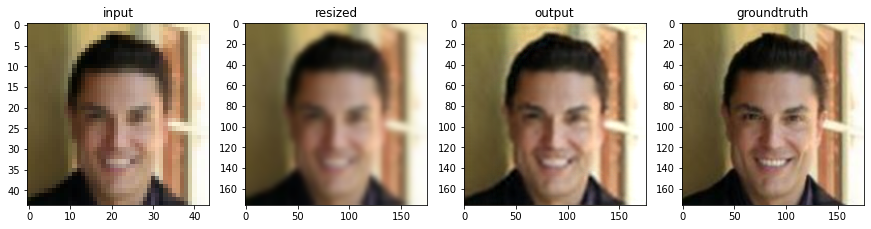

In [ ]:
test_idx = 30

x1_test = np.load(x_test_list[test_idx])
x1_test_resized = pyramid_expand(x1_test, 4, multichannel=True)
y1_test = np.load(y_test_list[test_idx])
y_pred = model.predict(x1_test.reshape((1, 44, 44, 3)))

print(x1_test.shape, y1_test.shape)

x1_test = (x1_test * 255).astype(np.uint8)
x1_test_resized = (x1_test_resized * 255).astype(np.uint8)
y1_test = (y1_test * 255).astype(np.uint8)
y_pred = np.clip(y_pred.reshape((176, 176, 3)), 0, 1)

x1_test = cv2.cvtColor(x1_test, cv2.COLOR_BGR2RGB)
x1_test_resized = cv2.cvtColor(x1_test_resized, cv2.COLOR_BGR2RGB)
y1_test = cv2.cvtColor(y1_test, cv2.COLOR_BGR2RGB)
y_pred = cv2.cvtColor(y_pred, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title('input')
plt.imshow(x1_test)
plt.subplot(1, 4, 2)
plt.title('resized')
plt.imshow(x1_test_resized)
plt.subplot(1, 4, 3)
plt.title('output')
plt.imshow(y_pred)
plt.subplot(1, 4, 4)
plt.title('groundtruth')
plt.imshow(y1_test)

(44, 44, 3) (176, 176, 3)


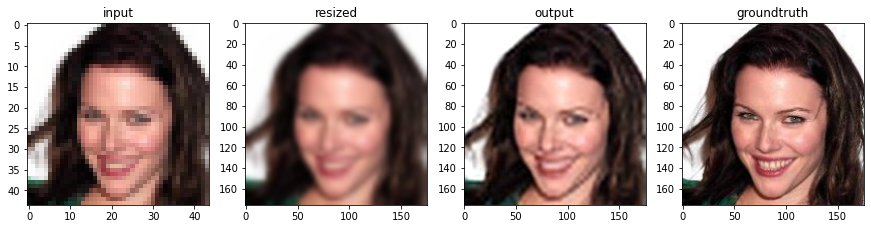

In [ ]:
test_idx = 60

x1_test = np.load(x_test_list[test_idx])
x1_test_resized = pyramid_expand(x1_test, 4, multichannel=True)
y1_test = np.load(y_test_list[test_idx])
y_pred = model.predict(x1_test.reshape((1, 44, 44, 3)))

print(x1_test.shape, y1_test.shape)

x1_test = (x1_test * 255).astype(np.uint8)
x1_test_resized = (x1_test_resized * 255).astype(np.uint8)
y1_test = (y1_test * 255).astype(np.uint8)
y_pred = np.clip(y_pred.reshape((176, 176, 3)), 0, 1)

x1_test = cv2.cvtColor(x1_test, cv2.COLOR_BGR2RGB)
x1_test_resized = cv2.cvtColor(x1_test_resized, cv2.COLOR_BGR2RGB)
y1_test = cv2.cvtColor(y1_test, cv2.COLOR_BGR2RGB)
y_pred = cv2.cvtColor(y_pred, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title('input')
plt.imshow(x1_test)
plt.subplot(1, 4, 2)
plt.title('resized')
plt.imshow(x1_test_resized)
plt.subplot(1, 4, 3)
plt.title('output')
plt.imshow(y_pred)
plt.subplot(1, 4, 4)
plt.title('groundtruth')
plt.imshow(y1_test)